This is the first draft of the Gaussian Likelihood compressor, a tool which takes some data as an input, and compresses them to a lower dimensional space where the likelihood is simply Gaussian.

In this notebook, you can find 3 tools: first of all, a way to generate the data in order to perform your experiments. 

Then, a compressor, which at this stage could either be an auto-encoder, an Information Maximising Neural Network, or Score Compression in all its various forms.

Finally, we apply a Normalising Flow to map it to a standard Gaussian.

# Data generation

In [1]:
# we write here the script to create our dataset, taken primarily from zupcx26 code
# we will add modules to import progressively 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pydelfi.priors as priors
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [3]:
lower = np.array([0.15, 0.55])
upper = np.array([1.10, 1.10])
prior = priors.Uniform(lower, upper)

In [4]:
# we define a few hyper parameters here
np.random.seed(13)
n = 1000 # total number of data points for NF
n_sims = n  # total number of points for drawing
n_class = 1 # number of different cosmologies for the training

In [5]:
# load the parameters, \Omega_M and \sigma_8
parameters = np.loadtxt('./power_spectra/parameters_rep_wider.txt')[:n_sims]
#from scipy.spatial import distance
#print(parameters.shape)
#print(np.reshape(q_fid, [-1, 1]).shape)
#print(distance.cdist(np.reshape(q_fid, [1, -1]), parameters).min(axis=1))
#index = np.argmin(distance.cdist(np.reshape(q_fid, [1, -1]), parameters))
#print(parameters[index])

In [6]:
# in order to perform the compressions, we need a few things
n_vec = 49
lmax = 50
q_fid = [0.5, 0.7*np.sqrt(0.5/0.3)]
mul_mode_fac = 10.
Cl_fid = np.loadtxt('./power_spectra/der_power_spectrum_0.dat')[2:, 1]
mu = np.asarray(Cl_fid)
Cinv = mul_mode_fac*(2*np.arange(n_vec)+1) * np.eye(n_vec)/ (2*Cl_fid**2)
# now with the derivatives
mu_p1 = np.loadtxt('./power_spectra/der_power_spectrum_1.dat')[2:, 1]
mu_p2 = np.loadtxt('./power_spectra/der_power_spectrum_2.dat')[2:, 1]
h = 0.01
dmudt = np.zeros([2, n_vec])
dmudt[0] = (mu_p1 - mu)/h
dmudt[1] = (mu_p2 - mu)/h
#dmudt = np.reshape(dmudt, [2, -1])

# now we define the score compression
Compressor = score.Gaussian(n_vec, q_fid, mu = mu, Cinv = Cinv, dmudt = dmudt)
Compressor.compute_fisher()
Finv = Compressor.Finv

def compressor(d, compressor_args=None):
    return Compressor.scoreMLE(d)
compressor_args=None

In [7]:
Cinv

array([[3.04012998e+17, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.37107766e+18, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 8.05482464e+18, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.29669932e+23, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 4.76843092e+23, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 5.28464187e+23]])

In [8]:
# we now create the data needed for the normalising flow
# we create the observed data point, for now at the fiducial value of q
#q_fid = q_fid  # new observation, different from the compression
np.random.seed(13)
q_obs = np.loadtxt('./power_spectra/parameters_rep_wider.txt')[1000] #[0.5, 0.7*np.sqrt(0.5/0.3)] #np.loadtxt('./power_spectra/parameters_rep_wider.txt')[1000]
d_vec_obs = np.zeros((1, n_vec)) 
for index in range(1):
    load = np.loadtxt('./power_spectra/power_spectrum_1000.dat') #np.loadtxt('./power_spectra/der_power_spectrum_0.dat') #np.loadtxt('./power_spectra/power_spectrum_1000.dat')
    cls = load[:, 1]
    single = []
    for ell in range(2, lmax+1):
        shape = mul_mode_fac*(2*ell+1)/2
        location = 2*cls[ell]/(mul_mode_fac*(2*ell+1))
        single.append(np.random.gamma(shape, location))
    d_vec_obs[index] = single
d_vec_obs = load[2:, 1]
d_vec_obs = np.reshape(d_vec_obs, [1, -1])

lmax = 50
# we also create the data for the training
d_vec_q = np.zeros((n_sims, n_vec))
power_spectra = []
for index in range(n_sims):
    load = np.loadtxt(f'./power_spectra/power_spectrum_{index}.dat')
    cls = load[:, 1]
    single = []
    for ell in range(2, lmax+1):
        shape =  mul_mode_fac*(2*ell+1)/2
        location = 2*cls[ell]/(mul_mode_fac*(2*ell+1))
        single.append(np.random.gamma(shape, location))
    d_vec_q[index] = single
    
d_vec_obs_keep = np.copy(d_vec_obs)
print(d_vec_q.shape, d_vec_obs.shape)

(1000, 49) (1, 49)


In [9]:
d_vec_obs

array([[2.20988324e-09, 1.39308811e-09, 9.83102681e-10, 7.42816198e-10,
        5.86937767e-10, 4.78653885e-10, 3.99625846e-10, 3.39831272e-10,
        2.93242857e-10, 2.36417106e-10, 2.07638019e-10, 1.83943079e-10,
        1.64171592e-10, 1.47481596e-10, 1.33249374e-10, 1.21004155e-10,
        1.10340251e-10, 1.01109375e-10, 9.29526293e-11, 8.57481505e-11,
        7.93328652e-11, 7.36226805e-11, 6.84882937e-11, 6.38725126e-11,
        5.96953017e-11, 5.59091084e-11, 5.24510612e-11, 4.93051897e-11,
        4.64393545e-11, 4.37970253e-11, 4.13658119e-11, 3.91296830e-11,
        3.70586723e-11, 3.51430540e-11, 3.33683009e-11, 3.17122756e-11,
        3.01713136e-11, 2.87410911e-11, 2.74086747e-11, 2.61571732e-11,
        2.49833310e-11, 2.38843891e-11, 2.28527942e-11, 2.18789969e-11,
        2.09617494e-11, 2.01002327e-11, 1.92909451e-11, 1.85275014e-11,
        1.78026125e-11]])

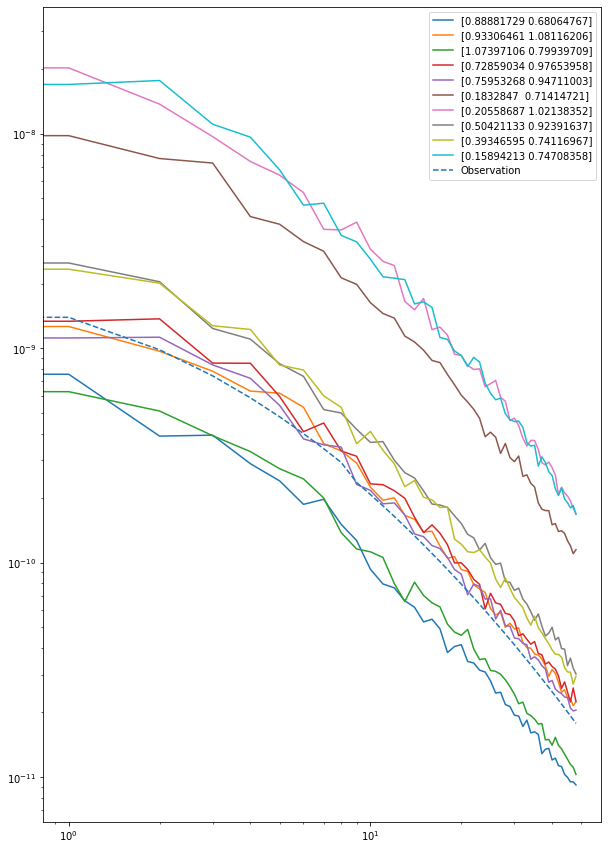

In [10]:
# we plot a few things to make sure everything is good
plt.figure(figsize=(10, 15))
for index in range(10):
    plt.loglog(np.arange(n_vec), d_vec_q[index], label=parameters[index])
#for index in range(n):
#    plt.plot(np.arange(n_vec), d_vec[index],)
plt.loglog(np.arange(n_vec), d_vec_obs[0], label='Observation', linestyle='--')
plt.legend();

In [11]:
# we need to retrieve all the needed summaries here, so:
# 1) the summary of the observation
# 2) the summaries of the noise realisations
summaries_noise = []
for index in range(n):
    summaries_noise.append(compressor(d_vec_q[index]))
summaries_noise = np.asarray(summaries_noise)
summary_obs = compressor(d_vec_obs[0])
summary_obs = np.reshape(summary_obs, [1, -1])

In [12]:
compressor(d_vec_obs[0])

array([0.56001857, 0.77322934])

In [13]:
compressed_data = summary_obs[0]

sim_params = parameters #np.reshape(q_prior, [-1, 1])

sim_compressed_data = summaries_noise

#Finv = np.genfromtxt('simulators/cosmic_shear/pre_ran_sims/Finv.dat')

theta_fiducial = np.array(q_fid)

## Create ensemble of NDEs


In [14]:
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=2, n_data=2, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=0),
        ndes.MixtureDensityNetwork(n_parameters=2, n_data=2, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
        ndes.MixtureDensityNetwork(n_parameters=2, n_data=2, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
        ndes.MixtureDensityNetwork(n_parameters=2, n_data=2, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
        ndes.MixtureDensityNetwork(n_parameters=2, n_data=2, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
        ndes.MixtureDensityNetwork(n_parameters=2, n_data=2, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=5)]

## Create DELFI object

In [15]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs,  
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\Omega_m', 'S_8'], 
                            results_dir = "./attempt_results")

## Load simulations into DELFI object

In [16]:
DelfiEnsemble.load_simulations(sim_compressed_data, sim_params)

# Train the networks

In [17]:
DelfiEnsemble.train_ndes()

In [18]:
# this should give us the log-likelihood
n_bins = 50
xx = np.linspace(0.15, 1.10, n_bins, endpoint=True) #np.random.uniform(0, 1, n)
yy = np.linspace(0.55, 1.10, n_bins, endpoint=True) #np.random.uniform(0, 1, n)
xv, yv = np.meshgrid(xx, yy)
likelihood_arr = np.zeros((n_bins*n_bins, 3))
index = 0
for omega in xx:
    for es in yy:
        likelihood_arr[index, :] = omega, es, DelfiEnsemble.log_likelihood_stacked([omega, es], compressed_data)
        index += 1

In [19]:
likelihood_arr

array([[ 0.15      ,  0.55      , -3.7122252 ],
       [ 0.15      ,  0.56122449, -3.81051159],
       [ 0.15      ,  0.57244898, -3.89359379],
       ...,
       [ 1.1       ,  1.07755102, -3.46435475],
       [ 1.1       ,  1.08877551, -3.67283392],
       [ 1.1       ,  1.1       , -3.50751877]])

In [20]:
likelihood_arr = np.reshape(np.asarray(likelihood_arr), (-1, 3))
likelihood_arr[:, 2] = np.exp(likelihood_arr[:, 2])  # return to likelihood
like_norm = np.sum(likelihood_arr[:, 2])
likelihood_arr[:, 2] = likelihood_arr[:, 2] / like_norm

In [21]:
omega_m_obs, S8_obs = q_obs[0], q_obs[1]

In [22]:
# we retrieve the real posterior here
# a few things that will be useful later on
from scipy.stats import gamma
ell = np.arange(2, lmax+1)
shape = mul_mode_fac*(2*ell+1)/2

likelihood_arr_true = np.zeros((n_bins*n_bins, 3))
index = 0

# and we evaluate the likelihood here
for i in xx:
    for j in yy:
        load = np.loadtxt(f'./power_spectra/power_spectrum_{i}_{j}.dat')
        cls = load[:, 1]
        scale = 2*cls[ell]/(mul_mode_fac*(2*ell+1))
        evaluation = gamma.pdf(x=d_vec_obs[0], a=shape, loc=0, scale=scale)  # the scipy gamma distribution has a slightly different definition than the numpy one
        likelihood = np.prod(evaluation/3e12)
        likelihood_arr_true[index, :] = i, j, likelihood
        index += 1
like_norm_true = np.sum(likelihood_arr_true[:, 2])
likelihood_arr_true[:, 2] = likelihood_arr_true[:, 2] / like_norm_true

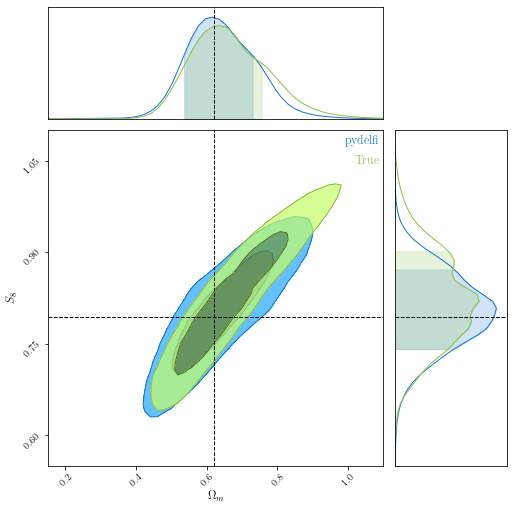

In [23]:
from chainconsumer import ChainConsumer
xs = likelihood_arr[:, 0]
ys = likelihood_arr[:, 1]
#ys = ys/np.sqrt(xs/0.3)
pdf_flat = likelihood_arr[:, 2]

xs_true = likelihood_arr_true[:, 0]
ys_true = likelihood_arr_true[:, 1]
#ys = ys/np.sqrt(xs/0.3)
pdf_flat_true = likelihood_arr_true[:, 2]

c = ChainConsumer()
c.add_chain([xs, ys], parameters=["$\Omega_m$", "$S_8$"], weights=pdf_flat, grid=True, name='pydelfi')
c.add_chain([xs_true, ys_true], parameters=["$\Omega_m$", "$S_8$"], weights=pdf_flat_true, grid=True, name='True')
c.configure(smooth=1.5)  # Notice how smoothing changes the results!
fig = c.plotter.plot(truth=[omega_m_obs, S8_obs])

fig.set_size_inches(4.5 + fig.get_size_inches())  

In [18]:
import scipy.special as sps
theo_post = np.zeros((n_bins, 2))
for i, q in enumerate(sim_params):
    y = 1
    scale = q/n_vec
    for j in range(1, n_vec+1):
        shape = j / q**2
        y *= d_vec_obs[0, j-1]**(shape-1)*(np.exp(-d_vec_obs[0, j-1]/scale) / (sps.gamma(shape)*scale**shape))
    theo_post[i] = q, y
theo_post[:, 1] = theo_post[:, 1] / np.sum(theo_post[:, 1])

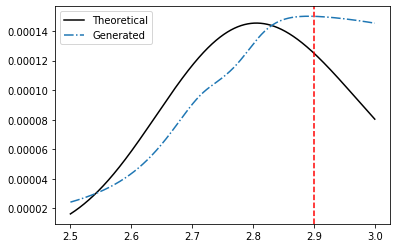

In [19]:
plt.plot(theo_post[:, 0],  theo_post[:, 1], c='k', label='Theoretical')
plt.plot(likelihood_arr[:, 0], likelihood_arr[:, 1], linestyle='-.', label='Generated')
plt.legend()
plt.axvline(q_fid_obs, linestyle='--', color='r')